In [1]:
# Load reverse_query_index, reverse ranker
# Find subset of passages that are not in train set: take the first 100 of them
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Load forward_passage_index, forward ranker
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average

In [20]:
from annoy import AnnoyIndex
import torch
import sys
import random

sys.path.insert(0, '/home/jianx/search-exposure/forward_ranker/')
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from train import generate_sparse
from load_data import obj_reader, obj_writer
import network

from annoy import AnnoyIndex
from utils import print_message

EMBED_SIZE = 256
DEVICE = "cuda:0"
n_passage = 100
n_query = 100
rank = 100

REVERSE_INDEX_PATH = "./results/128_200000_0.8_index.ann"
REVERSE_RANKER_PATH = "./results/200000_samples_0.8_neg200_10_500_0.001_256_10.model"
FORWARD_INDEX_PATH = "/home/jianx/data/annoy/128_passage_index.ann"
FORWARD_RANKER_PATH = "/home/jianx/data/results/100_1000_1000_0.001_256_10.model"
PASSAGE_DICT_PATH = "/home/jianx/data/passages.dict"
QUERY_TRAIN_DICT_PATH = "/home/jianx/data/queries_train.dict"
TRAIN_RANK_PATH = "/home/jianx/data/train_data/256_200000_100_100_training.csv"
REVERSE_MAP_PATH = "./results/128_200000_0.8_map.dict"
FORWARD_MAP_PATH = "/home/jianx/data/annoy/128_pid_map.dict"
FORWARD_QUERY_INDEX = "/home/jianx/data/annoy/128_query_index.ann"
FORWARD_QUERY_MAP = "/home/jianx/data/annoy/128_qid_map.dict"

In [21]:
def load_train(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split(",")
            pid = int(tokens[0])
            qid = int(tokens[1])
            rank = int(tokens[2].rstrip())
            if pid not in my_dict:
                my_dict[pid] = {}
            my_dict[pid][qid] = rank
            line = file.readline()
    return my_dict
def load():
    query_dict = obj_reader(QUERY_TRAIN_DICT_PATH)
    passage_dict = obj_reader(PASSAGE_DICT_PATH)
    train_rank_dict = load_train(TRAIN_RANK_PATH)
    return train_rank_dict, query_dict, passage_dict

In [22]:
import torch.nn as nn

NUM_HIDDEN_NODES = 64
NUM_HIDDEN_LAYERS = 3
DROPOUT_RATE = 0.1
FEAT_COUNT = 100000


# Define the network
class DSSM(torch.nn.Module):

    def __init__(self, embed_size):
        super(DSSM, self).__init__()

        layers = []
        last_dim = FEAT_COUNT
        for i in range(NUM_HIDDEN_LAYERS):
            layers.append(nn.Linear(last_dim, NUM_HIDDEN_NODES))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(NUM_HIDDEN_NODES))
            layers.append(nn.Dropout(p=DROPOUT_RATE))
            last_dim = NUM_HIDDEN_NODES
        layers.append(nn.Linear(last_dim, embed_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def parameter_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [23]:
# Load reverse query index
reverse_query_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
reverse_query_index.load(REVERSE_INDEX_PATH)
# Load reverse query index mapping dict
reverse_query_map = obj_reader(REVERSE_MAP_PATH)
# Load reverse ranker model
reverse_ranker = DSSM(embed_size=EMBED_SIZE)
reverse_ranker.load_state_dict(torch.load(REVERSE_RANKER_PATH))
reverse_ranker.to(DEVICE)
reverse_ranker.eval()
# Load forward passage index
forward_passage_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
forward_passage_index.load(FORWARD_INDEX_PATH)
# Load forward passage index mapping dict 
forward_passage_map = obj_reader(FORWARD_MAP_PATH)
# Load forward ranker model
forward_ranker = network.DSSM(embed_size=EMBED_SIZE)
forward_ranker.load_state_dict(torch.load(FORWARD_RANKER_PATH))
forward_ranker.to(DEVICE)
forward_ranker.eval()
# Load train_rank, query, passage dict
train_rank_dict, query_dict, passage_dict = load()

In [24]:
# Load forward query index
forward_query_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
forward_query_index.load(FORWARD_QUERY_INDEX)
# Load forward query index mapping dict 
forward_query_map = obj_reader(FORWARD_QUERY_MAP)

In [25]:
# Find subset of passages that are not in train set: take the first 100 of them
train_passage_list = set(list(train_rank_dict.keys()))
all_passage_list = set(list(passage_dict.keys()))
test_passage_list = list(all_passage_list.difference(train_passage_list))

In [26]:
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average
random_test_passage = random.sample(test_passage_list, n_passage)
# random_test_passage = random.sample(list(train_passage_list), n_passage)
counter = 0
rankings = []
total_sum = 0
match_count = 0
non_zero = []
forward_benchmark = 0
test_results_forward = {}
test_results_reverse = {}
for i, pid in enumerate(random_test_passage):
    temp_results_forward = {}
    temp_results_reverse = {}
    temp_reverse = 0
    temp_forward = 0
    print_message("Processing passage No. " + str(i+1) + "/" + str(n_passage))
    embedding = reverse_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries = reverse_query_index.get_nns_by_vector(embedding, n_query)
    embedding_forward = forward_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries_forward = forward_query_index.get_nns_by_vector(embedding_forward, n_query)
    matching_list = []
    print("Reverse:")
    for i, annoy_qid in enumerate(nearest_queries):
        qid = reverse_query_map[annoy_qid]
        top_list = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for j, annoy_pid in enumerate(top_list):
            if forward_passage_map[annoy_pid] == pid:
                print("qid {}: rank {}".format(qid,j+1))
                temp_results_reverse[qid] = j+1
                matching_list.append(j + 1)
                non_zero.append(j + 1)
                is_matched = True
                match_count += 1
                temp_reverse += 1
                break
            if not is_matched:
                matching_list.append(0)
    print("Forward:")
    for k, annoy_qid_f in enumerate(nearest_queries_forward):
        qid_f = forward_query_map[annoy_qid_f]
        top_list_f = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid_f]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for t, annoy_pid_f in enumerate(top_list_f):
            if forward_passage_map[annoy_pid_f] == pid:
                print("qid {}: rank {}".format(qid_f,t+1))
                temp_results_forward[qid_f] = t+1
                is_matched = True
                temp_forward += 1
                break
            if not is_matched:
                matching_list.append(0)    
    total_sum += sum(matching_list)
    rankings.append(matching_list)
    counter += 1
    forward_benchmark += temp_forward
    test_results_forward[pid] = temp_results_forward
    test_results_reverse[pid] = temp_results_reverse
    print("{}: Forward: {} Reverse: {}".format(pid, temp_forward, temp_reverse))
print("Forward: {} Reverse: {}".format(forward_benchmark/ n_passage, match_count / n_passage))

[Jul 24, 00:52:34] Processing passage No. 1/100
Reverse:
qid 669286: rank 49
Forward:
qid 669286: rank 49
6904139: Forward: 1 Reverse: 1
[Jul 24, 00:52:37] Processing passage No. 2/100
Reverse:
qid 938005: rank 3
Forward:
qid 95333: rank 6
qid 938005: rank 3
qid 859083: rank 13
qid 516388: rank 59
qid 345156: rank 56
qid 804326: rank 95
8724038: Forward: 6 Reverse: 1
[Jul 24, 00:52:39] Processing passage No. 3/100
Reverse:
Forward:
2311512: Forward: 0 Reverse: 0
[Jul 24, 00:52:41] Processing passage No. 4/100
Reverse:
Forward:
2692061: Forward: 0 Reverse: 0
[Jul 24, 00:52:44] Processing passage No. 5/100
Reverse:
qid 752357: rank 11
qid 658300: rank 50
qid 932083: rank 52
qid 522612: rank 61
Forward:
qid 752357: rank 11
qid 522612: rank 61
qid 932083: rank 52
qid 658300: rank 50
3959772: Forward: 4 Reverse: 4
[Jul 24, 00:52:46] Processing passage No. 6/100
Reverse:
qid 683396: rank 10
qid 90537: rank 74
Forward:
qid 683396: rank 10
qid 90537: rank 74
371155: Forward: 2 Reverse: 2
[Jul 

qid 548414: rank 67
qid 1152266: rank 13
qid 126804: rank 48
6629788: Forward: 59 Reverse: 40
[Jul 24, 00:53:31] Processing passage No. 26/100
Reverse:
qid 944727: rank 29
Forward:
qid 109850: rank 40
qid 944727: rank 29
qid 305642: rank 83
qid 1154147: rank 32
qid 812563: rank 67
qid 809417: rank 82
1254887: Forward: 6 Reverse: 1
[Jul 24, 00:53:33] Processing passage No. 27/100
Reverse:
qid 195395: rank 31
qid 1072866: rank 99
Forward:
qid 195395: rank 31
qid 1072866: rank 99
4266446: Forward: 2 Reverse: 2
[Jul 24, 00:53:35] Processing passage No. 28/100
Reverse:
qid 155574: rank 29
qid 549939: rank 28
Forward:
qid 1179356: rank 29
qid 155574: rank 29
qid 549939: rank 28
qid 376482: rank 83
3664667: Forward: 4 Reverse: 2
[Jul 24, 00:53:38] Processing passage No. 29/100
Reverse:
qid 147093: rank 57
qid 368587: rank 25
qid 443469: rank 15
qid 121160: rank 33
qid 417421: rank 21
qid 406046: rank 71
qid 439811: rank 21
qid 186919: rank 68
qid 338747: rank 43
Forward:
qid 368587: rank 25
q

qid 194111: rank 39
qid 730094: rank 46
2308941: Forward: 5 Reverse: 3
[Jul 24, 00:54:36] Processing passage No. 55/100
Reverse:
Forward:
5518904: Forward: 0 Reverse: 0
[Jul 24, 00:54:39] Processing passage No. 56/100
Reverse:
qid 902565: rank 31
qid 902811: rank 77
qid 553519: rank 67
qid 526169: rank 78
qid 153919: rank 8
qid 230404: rank 100
qid 288855: rank 81
qid 1551: rank 90
qid 232328: rank 30
qid 845853: rank 41
qid 1146294: rank 25
qid 277076: rank 57
qid 288892: rank 63
qid 232312: rank 58
qid 230672: rank 51
qid 472715: rank 25
qid 359143: rank 86
Forward:
qid 153919: rank 8
qid 232328: rank 30
qid 1551: rank 90
qid 1146294: rank 25
qid 902565: rank 31
qid 230404: rank 100
qid 845853: rank 41
qid 359143: rank 86
qid 902811: rank 77
qid 288855: rank 81
qid 526169: rank 78
qid 288892: rank 63
qid 230672: rank 51
qid 277076: rank 57
qid 553519: rank 67
qid 464474: rank 61
qid 286217: rank 74
qid 538980: rank 58
qid 782916: rank 25
qid 288856: rank 71
qid 472715: rank 25
qid 23

Reverse:
qid 1080243: rank 83
qid 541528: rank 61
Forward:
qid 1080243: rank 83
qid 541528: rank 61
3290217: Forward: 2 Reverse: 2
[Jul 24, 00:55:24] Processing passage No. 77/100
Reverse:
qid 214501: rank 17
qid 1080025: rank 69
qid 47374: rank 26
Forward:
qid 214501: rank 17
qid 143449: rank 55
qid 47374: rank 26
qid 1080025: rank 69
3445468: Forward: 4 Reverse: 3
[Jul 24, 00:55:26] Processing passage No. 78/100
Reverse:
qid 29527: rank 44
qid 482626: rank 24
qid 81818: rank 6
Forward:
qid 81818: rank 6
qid 482626: rank 24
qid 29527: rank 44
qid 618140: rank 81
4258879: Forward: 4 Reverse: 3
[Jul 24, 00:55:28] Processing passage No. 79/100
Reverse:
qid 432167: rank 66
qid 409434: rank 63
qid 1179405: rank 3
qid 331120: rank 16
qid 282294: rank 84
qid 1140183: rank 92
Forward:
qid 1179405: rank 3
qid 331120: rank 16
qid 101264: rank 54
qid 409434: rank 63
qid 282294: rank 84
qid 283875: rank 75
qid 1140183: rank 92
qid 432167: rank 66
3848395: Forward: 8 Reverse: 6
[Jul 24, 00:55:30] 

qid 509942: rank 72
qid 921038: rank 47
Forward:
qid 194565: rank 17
qid 197252: rank 10
qid 921038: rank 47
qid 116273: rank 79
qid 969856: rank 68
qid 509942: rank 72
qid 662508: rank 31
qid 470622: rank 90
qid 666066: rank 82
2613081: Forward: 9 Reverse: 4
[Jul 24, 00:56:14] Processing passage No. 100/100
Reverse:
qid 285388: rank 74
qid 909022: rank 63
Forward:
qid 913500: rank 47
qid 909022: rank 63
qid 285388: rank 74
5844675: Forward: 3 Reverse: 2
Forward: 7.11 Reverse: 4.74


In [27]:
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average
# random_test_passage = random.sample(test_passage_list, n_passage)
random_test_passage = random.sample(list(train_passage_list), n_passage)
counter = 0
rankings = []
total_sum = 0
match_count = 0
non_zero = []
forward_benchmark = 0
train_results_forward = {}
train_results_reverse = {}
for i, pid in enumerate(random_test_passage):
    temp_results_forward = train_rank_dict[pid]
    temp_results_reverse = {}
    temp_forward = len(temp_results_forward)
    forward_benchmark += temp_forward
    temp_reverse = 0
    print_message("Processing passage No. " + str(i+1) + "/" + str(n_passage))
    embedding = reverse_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries = reverse_query_index.get_nns_by_vector(embedding, n_query)
    matching_list = []

    for i, annoy_qid in enumerate(nearest_queries):
        qid = reverse_query_map[annoy_qid]
        top_list = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for j, annoy_pid in enumerate(top_list):
            if forward_passage_map[annoy_pid] == pid:
#                 print("Match!!!!! Rank: " + str(j + 1))
                temp_results_reverse[qid] = j+1
                matching_list.append(j + 1)
                non_zero.append(j + 1)
                is_matched = True
                match_count += 1
                temp_reverse += 1
                break
            if not is_matched:
                matching_list.append(0)
    total_sum += sum(matching_list)
    rankings.append(matching_list)
    counter += 1
    train_results_forward[pid] = temp_results_forward
    train_results_reverse[pid] = temp_results_reverse
    print("Reverse: {}".format(temp_results_reverse))
    print("Forward: {}".format(temp_results_forward))
    print("{}: Forward: {} Reverse: {}".format(pid, temp_forward, temp_reverse))
print("Forward: {} Reverse: {}".format(forward_benchmark/ n_passage, match_count / n_passage))

[Jul 24, 00:56:16] Processing passage No. 1/100
Reverse: {222711: 94}
Forward: {222711: 94}
3891131: Forward: 1 Reverse: 1
[Jul 24, 00:56:17] Processing passage No. 2/100
Reverse: {625211: 5, 231743: 19, 1032982: 75, 241680: 15, 432195: 22, 425065: 64, 425064: 90, 1174776: 50, 949832: 42, 1033314: 83, 355034: 49}
Forward: {1174776: 50, 625211: 5, 949832: 42, 241680: 15, 231743: 19, 425065: 64, 425064: 90, 510712: 65, 1032982: 75, 430210: 82, 750723: 79, 432195: 22, 1033314: 83, 355034: 49}
6353891: Forward: 14 Reverse: 11
[Jul 24, 00:56:18] Processing passage No. 3/100
Reverse: {472376: 7, 1046817: 17, 676538: 23, 534698: 34, 1152588: 41, 990121: 64, 552476: 75, 279828: 66}
Forward: {472376: 7, 676538: 23, 1046817: 17, 534698: 34, 1152588: 41, 990121: 64, 552476: 75}
1910050: Forward: 7 Reverse: 8
[Jul 24, 00:56:19] Processing passage No. 4/100
Reverse: {1036242: 34}
Forward: {1036242: 34}
2564828: Forward: 1 Reverse: 1
[Jul 24, 00:56:20] Processing passage No. 5/100
Reverse: {369915: 

Reverse: {1045431: 37, 346513: 87, 1042134: 22}
Forward: {1045431: 37, 346513: 87, 1042134: 22, 891736: 65}
7591821: Forward: 4 Reverse: 3
[Jul 24, 00:56:50] Processing passage No. 33/100
Reverse: {650697: 17, 1043175: 2, 828052: 10, 1149073: 32, 184007: 7, 1065432: 13, 358735: 29, 713042: 32, 1079595: 34, 523405: 17, 785280: 52, 630529: 54, 184776: 58, 903551: 77, 7478: 26, 758864: 66, 226278: 90, 662831: 53, 1169922: 31}
Forward: {1043175: 2, 1076248: 12, 184007: 7, 1065432: 13, 630529: 54, 903551: 77, 523405: 17, 713042: 32, 1079595: 34, 828052: 10, 687520: 65, 7478: 26, 650697: 17, 1169922: 31, 226278: 90, 358735: 29, 708070: 32, 490675: 37, 758864: 66, 537602: 53, 1149073: 32, 785280: 52, 863037: 93, 889082: 86, 184776: 58, 17744: 96, 662831: 53, 58798: 98, 355067: 40, 1015126: 85}
5835391: Forward: 30 Reverse: 19
[Jul 24, 00:56:51] Processing passage No. 34/100
Reverse: {578068: 7, 953517: 16, 287291: 37, 195979: 25, 784835: 87, 235812: 91}
Forward: {953517: 16, 195979: 25, 57806

Reverse: {1073344: 70, 483020: 1, 221683: 6, 947130: 28, 1052153: 68, 1043075: 85, 1155631: 53, 241043: 31, 1169187: 55, 975380: 74}
Forward: {483020: 1, 947130: 28, 927148: 11, 775584: 42, 1073344: 70, 948285: 65, 939704: 96, 1155631: 53, 221683: 6, 1052153: 68, 573757: 22, 534139: 28, 8524: 85, 1043075: 85, 241043: 31, 946252: 83, 1050922: 41, 975380: 74, 562744: 48, 947129: 100, 487124: 100, 1024503: 46, 556048: 68, 446711: 68, 1169187: 55}
2715123: Forward: 25 Reverse: 10
[Jul 24, 00:57:19] Processing passage No. 60/100
Reverse: {82105: 34, 20715: 82, 965113: 82, 1160981: 42, 340315: 23, 865291: 44}
Forward: {340315: 23, 1160981: 42, 82105: 34, 20715: 82, 965113: 82, 865291: 44}
2162926: Forward: 6 Reverse: 6
[Jul 24, 00:57:20] Processing passage No. 61/100
Reverse: {597723: 12, 779388: 39, 485374: 1, 1070711: 6, 471093: 71, 1062955: 81, 1067295: 81, 1005241: 11, 457341: 19, 147664: 75}
Forward: {485374: 1, 597723: 12, 457341: 19, 1070711: 6, 779388: 39, 1005241: 11, 1062955: 81, 1

Reverse: {761872: 3, 141710: 72, 696512: 33, 696855: 28}
Forward: {761872: 3, 162318: 11, 141710: 72, 696855: 28, 595184: 95, 696512: 33, 378947: 27}
4779815: Forward: 7 Reverse: 4
[Jul 24, 00:57:57] Processing passage No. 95/100
Reverse: {372707: 27, 362452: 30, 1053040: 35, 210479: 61, 1037961: 38, 897366: 56, 1029573: 58, 565406: 44}
Forward: {372707: 27, 1053040: 35, 362452: 30, 210479: 61, 897366: 56, 1029573: 58, 1037961: 38, 565406: 44}
4012736: Forward: 8 Reverse: 8
[Jul 24, 00:57:58] Processing passage No. 96/100
Reverse: {891590: 33, 989807: 43}
Forward: {989807: 43, 891590: 33}
1618718: Forward: 2 Reverse: 2
[Jul 24, 00:57:59] Processing passage No. 97/100
Reverse: {189205: 85, 361327: 58, 693299: 81, 1154223: 67}
Forward: {1154223: 67, 189205: 85, 361327: 58, 693299: 81}
4592227: Forward: 4 Reverse: 4
[Jul 24, 00:58:00] Processing passage No. 98/100
Reverse: {360130: 62}
Forward: {360130: 62, 350071: 80}
3893861: Forward: 2 Reverse: 1
[Jul 24, 00:58:01] Processing passage N

In [30]:
# Check if reverse ranker can extract more relevant queires 
# compared to forward ranker
for pid in list(test_results_forward.keys()):   
    forward_set = set(test_results_forward[pid].values())
    reverse_set = set(test_results_reverse[pid].values())
    diff_set = reverse_set.difference(forward_set)
    if len(diff_set) != 0:
        print("pid: {} {}".format(pid, diff_set))
        print("Reverse: {}".format(test_results_reverse[pid]))
        print("Forward: {}".format(test_results_forward[pid]))
        print("____________________________________________________________________________________________________________________________")

pid: 2597519 {94}
Reverse: {561738: 35, 401366: 100, 1167865: 81, 188119: 98, 845353: 40, 952079: 65, 952076: 65, 952077: 65, 395417: 27, 251447: 94, 176997: 13, 741952: 65}
Forward: {561738: 35, 176997: 13, 845353: 40, 188119: 98, 1167865: 81, 401366: 100, 395417: 27, 952079: 65, 952076: 65, 952077: 65, 741952: 65, 395381: 91, 381765: 95}
____________________________________________________________________________________________________________________________
pid: 6629788 {40, 90, 61, 78}
Reverse: {866881: 2, 554386: 2, 1138858: 22, 1075879: 71, 1142832: 1, 711: 57, 799931: 7, 601741: 9, 1033619: 4, 126804: 48, 1154723: 65, 548414: 67, 913272: 22, 462971: 18, 728863: 61, 1023843: 90, 710407: 50, 837645: 30, 579993: 11, 391468: 40, 703879: 74, 1141606: 68, 715530: 66, 338337: 78, 1000602: 27, 1152464: 22, 118829: 7, 825082: 28, 870385: 16, 1163026: 16, 998256: 53, 163094: 2, 816529: 28, 920883: 84, 799206: 9, 116086: 66, 638243: 56, 903664: 65, 630723: 13, 926444: 41}
Forward: {55438

In [31]:
# Check if reverse ranker can extract more relevant queires 
# compared to forward ranker
for pid in list(train_results_forward.keys()):   
    forward_set = set(train_results_forward[pid].values())
    reverse_set = set(train_results_reverse[pid].values())
    diff_set = reverse_set.difference(forward_set)
    if len(diff_set) != 0:
        print("pid: {} {}".format(pid, diff_set))
        print("Reverse: {}".format(train_results_reverse[pid]))
        print("Forward: {}".format(train_results_forward[pid]))
        print("____________________________________________________________________________________________________________________________")

pid: 1910050 {66}
Reverse: {472376: 7, 1046817: 17, 676538: 23, 534698: 34, 1152588: 41, 990121: 64, 552476: 75, 279828: 66}
Forward: {472376: 7, 676538: 23, 1046817: 17, 534698: 34, 1152588: 41, 990121: 64, 552476: 75}
____________________________________________________________________________________________________________________________
pid: 2450106 {98, 61}
Reverse: {1044036: 67, 1041386: 98, 234790: 96, 23123: 36, 695076: 4, 543225: 81, 750833: 50, 376688: 61, 404018: 10, 19054: 47, 1026701: 84, 603589: 5, 955072: 50}
Forward: {962210: 12, 404018: 10, 695076: 4, 629114: 34, 603589: 5, 896649: 42, 918081: 15, 923828: 15, 1081238: 2, 972808: 74, 968514: 74, 1040250: 57, 25302: 9, 1026701: 84, 15670: 48, 23123: 36, 970445: 31, 19054: 47, 234790: 96, 1044036: 67, 978804: 33, 233235: 47, 1024051: 85, 681147: 50, 750833: 50, 975161: 88, 1045863: 23, 748014: 13, 543225: 81, 193289: 49, 1032744: 72}
_______________________________________________________________________________________

In [13]:
# Queries plain text: queries.train.tsv
# Passages plain text: collection.tsv
import csv
QUERIES_TEXT_PATH = "/home/jianx/data/queries.train.tsv"
PASSAGES_TEXT_PATH = "/home/jianx/data/collection.tsv"

def load_tsv_dict(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split("\t")
            indexid = int(tokens[0])
            text = tokens[1].rstrip()
            my_dict[indexid] = text
            line = file.readline()
    return my_dict

In [14]:
queries_text_dict = load_tsv_dict(QUERIES_TEXT_PATH)

In [15]:
passages_text_dict = load_tsv_dict(PASSAGES_TEXT_PATH)

In [16]:
# Example:
# pid: 4834361 {19}
# Reverse: {1003637: 90, 1140665: 91, 83569: 44, 540635: 19}
# Forward: {83569: 44, 1140665: 91, 1003637: 90, 205494: 52}
# _________________________________________________________________
def display_example(pid, foward_results_all, reverse_results_all):
    passage = passages_text_dict[pid]
    forward_results = foward_results_all[pid]
    reverse_results = reverse_results_all[pid]
    forward_set = set(forward_results.keys())
    reverse_set = set(reverse_results.keys())
    diff_set = reverse_set.difference(forward_set)
    print(diff_set)
    print("Passage:")
    print(passage)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("Forward:")
    for qid_f in list(forward_results.keys()):
        query = queries_text_dict[qid_f]
        rank = forward_results[qid_f]
        print("Rank: {} {}".format(rank, query))
    print("--------------------------------------------------------------")
    print("Reverse:")
    for qid_r in list(reverse_results.keys()):
        query = queries_text_dict[qid_r]
        rank = reverse_results[qid_r]
        if qid_r in diff_set:
            print("----New query detected by reverse ranker-----")
            print("Rank: {} {}".format(rank, query))
            print("---------------------------------------------")
        else:
            print("Rank: {} {}".format(rank, query))

In [32]:
display_example(6629788, test_results_forward, test_results_reverse)

{338337, 1023843, 1075879, 391468, 998256, 913272, 728863}
Passage:
General layout of electricity networks. Voltages and depictions of electrical lines are typical for Germany and other European systems. An electrical grid is an interconnected network for delivering electricity from suppliers to consumers. It consists of generating stations that produce electrical power, high voltage transmission lines that carry power from distant sources to demand centers, and distribution lines that connect individual customers.
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 2 what are 6 multiples of 1 3
Rank: 1 define shutter priority
Rank: 7 define causal relationship
Rank: 2 what kind of cell is a amoeba
Rank: 63 what is a vestige
Rank: 53 what is zyprexa prescribed for
Rank: 7 what is steve easterbrook responsible for
Rank: 11 what brands does adidas own
Rank: 2 does an amoeba produce an oocyst
Rank:

In [33]:
display_example(2597519, test_results_forward, test_results_reverse)

{251447}
Passage:
However, it depends. Some negative information can stay on your report for up to 15 years. Delinquencies (30 â 180 days): Up to 7 years after the first missed payment, the original delinquency date, after which point you never caught up on your payments again.
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 35 what are metric used for dynamic routing protocols
Rank: 13 dynamic website definition
Rank: 40 what is the salary of a director of risk management in ct?
Rank: 98 flower azalea worms
Rank: 81 weather in ingalls indiana
Rank: 100 is acc 200 safe during breastfeeding
Rank: 27 indiana workers compensation law definition
Rank: 65 when is the anniversary of vietnam war
Rank: 65 when is the anniversary  of the vietnam  war.
Rank: 65 when is the anniversary of the vietnam war
Rank: 65 what is dynamic data system
Rank: 91 indiana average medical director salary
Rank: 95 ho

In [35]:
 display_example(1748428, train_results_forward, train_results_reverse)

{780268, 225814}
Passage:
Even with its intuitive method, however, there are certain things to keep in mind when using the Train the Trainer approach. #1: Choose the right individuals to be trained. Train the Trainer allows you to address a larger number of employees while staying in budget. More teachers can translate to less money spent on travel, since employees can all learn from someone in their local network.
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 1 constantine name meaning
Rank: 9 how do you qualify for pca
Rank: 84 reynold name meaning
Rank: 19 What measure is one scoop of the dog food
Rank: 4 origin of the name constantine
Rank: 31 what is scoop/stack
Rank: 16 what medical problems does adderall treat
Rank: 77 define tuberous
Rank: 50 name meaning for elin
Rank: 65 what is zinc pca
Rank: 76 name meaning the one who brings peace
Rank: 37 bowling definitions
Rank: 86 define m

In [61]:
# A naive hypothesis:
# It seems that longer documment is less popular
# Below is the testing (count the number of words after we remove the stop words)
# Test on the train rank list

In [36]:
import matplotlib.pyplot as plt
passage_len = []
n_queries = []
for pid in list(train_rank_dict.keys()):
    n_queries.append(len(train_rank_dict[pid]))
    passage_len.append(len(passage_dict[pid]))

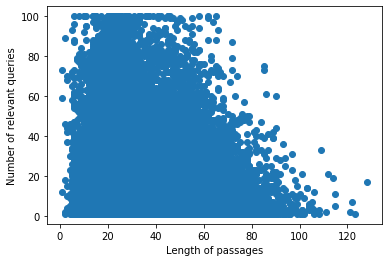

In [37]:
plt.xlabel("Length of passages")
plt.ylabel("Number of relevant queries")
plt.scatter(passage_len, n_queries)

In [65]:
# Visualize cosine similarity vs rank
# Use passage 666752 as an example

In [42]:
def compute_distance_rank(pid, forward_results, reverse_results):
    forward_distance = []
    forward_rank = []
    reverse_distance = []
    reverse_rank = []
    forward_result = forward_results[pid]
    reverse_result = reverse_results[pid]
    passage = generate_sparse(passage_dict[pid]).to(DEVICE)
    # forward embedding space
    for qid_f in list(forward_result.keys()):
        passage_f = forward_ranker(passage).unsqueeze(0).to(DEVICE)
        temp_q_f = forward_ranker(generate_sparse(query_dict[qid_f]).unsqueeze(0).to(DEVICE))
        distance_f = torch.cosine_similarity(passage_f, temp_q_f).item()
        forward_distance.append(distance_f)
        forward_rank.append(forward_result[qid_f])
        passage_f = forward_ranker(passage)
    # reverse embedding space
    for qid_r in list(reverse_result.keys()):
        passage_r = reverse_ranker(passage).unsqueeze(0).to(DEVICE)
        temp_q_r = reverse_ranker(generate_sparse(query_dict[qid_r]).unsqueeze(0).to(DEVICE))
        distance_r = torch.cosine_similarity(passage_r, temp_q_r).item()
        reverse_distance.append(distance_r)
        reverse_rank.append(reverse_result[qid_r])
    return forward_distance, forward_rank, reverse_distance, reverse_rank
    

In [44]:
def visualize_distance_rank(pid, forward_results, reverse_results):
    forward_distance, forward_rank, reverse_distance, reverse_rank = compute_distance_rank(pid, 
                                                                    forward_results, reverse_results)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Rank")
    plt.scatter(forward_distance, forward_rank, label = "Forward Ranker")
    plt.scatter(reverse_distance, reverse_rank, label = "Reverse Ranker")
    plt.legend()
    plt.show()

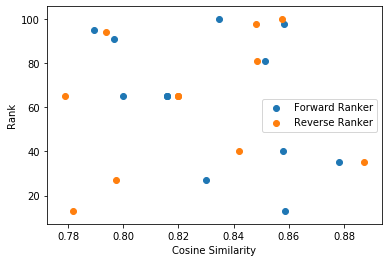

In [45]:
visualize_distance_rank(2597519, test_results_forward, test_results_reverse)

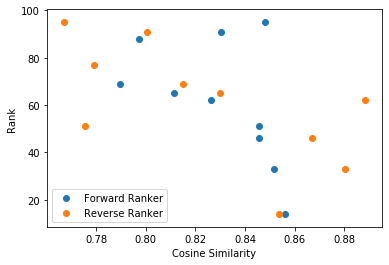

In [126]:
visualize_distance_rank(4342337, test_results_forward, test_results_reverse)

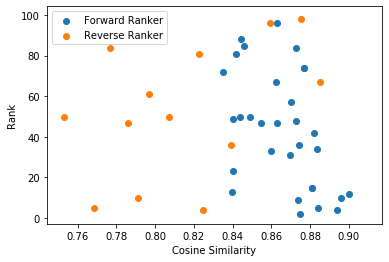

In [47]:
visualize_distance_rank(2450106, train_results_forward, train_results_reverse)

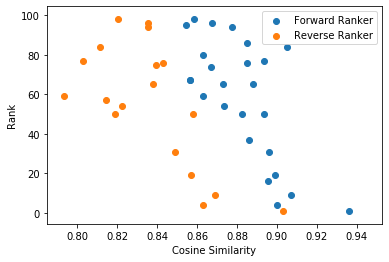

In [48]:
visualize_distance_rank(1748428, train_results_forward, train_results_reverse)

In [ ]:
def display_forward_examples()